**1. Ambil Data**

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Ambil data TSLA
data = yf.download("TSLA", period="max")
data = data[["Open", "High", "Low", "Close", "Volume"]]
data.head()


/tmp/ipython-input-1094022304.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TSLA", period="max")
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500


**2. Scaling Semua Feature**

In [2]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


**3. Buat Sequence untuk GRU**

In [3]:
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])   # multi-feature
    y.append(scaled_data[i, 3])                  # 3 = index kolom Close

X = np.array(X)
y = np.array(y)


**4. Split Train–Test**

In [4]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]


**5. Bangun Model GRU Multi-Feature**

In [5]:
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(64))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,657 (151.00 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 0 (0.00 B)

**6. Training Model**

In [6]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 5.8587e-05 - val_loss: 0.0012
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 6.4574e-05 - val_loss: 0.0011
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 5.1925e-05 - val_loss: 0.0015
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 5.4760e-05 - val_loss: 9.1971e-04
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 5.2550e-05 - val_loss: 8.9929e-04
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 4.5538e-05 - val_loss: 8.7967e-04
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 5.5965e-05 - val_loss: 8.5781e-04
Epoch 9/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 5.4249e-05 - val_loss: 7.8495e-04
Epoch 10/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 5.1739e-05 - val_loss: 8.6858e-04
Epoch 11/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 5.4259e-05 - val_loss: 0.00

In [7]:
# Simpan model ke format .keras
model.save("gru_tsla.keras")


In [8]:
from google.colab import files
files.download("gru_tsla.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**7. Prediksi**

In [9]:
pred_scaled = model.predict(X_test)

# Ambil scaler untuk hanya kolom Close
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]

pred_prices = close_scaler.inverse_transform(pred_scaled)
real_prices = close_scaler.inverse_transform(y_test.reshape(-1,1))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


**8. Plot Hasil Prediksi**

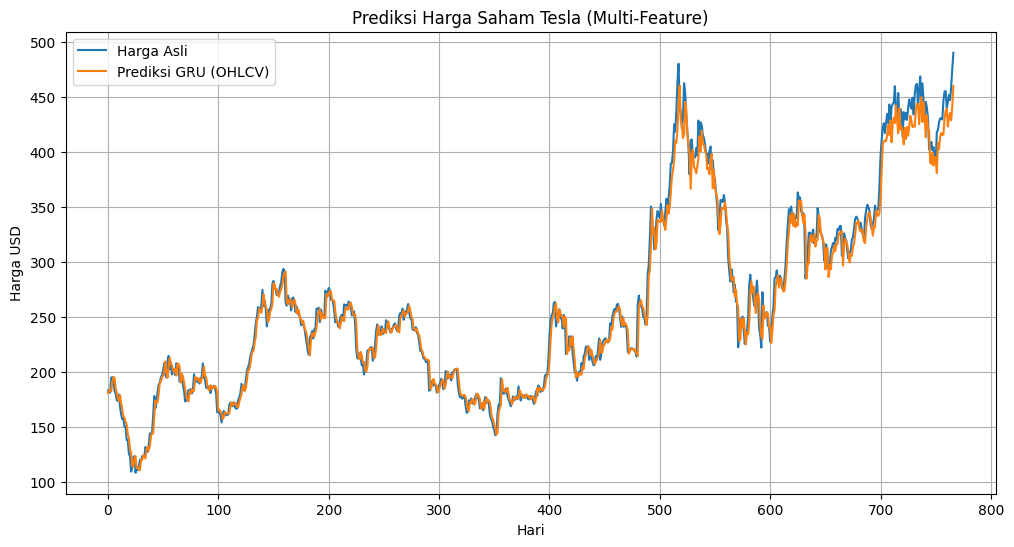

In [10]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Harga Asli")
plt.plot(pred_prices, label="Prediksi GRU (OHLCV)")
plt.title("Prediksi Harga Saham Tesla (Multi-Feature)")
plt.xlabel("Hari")
plt.ylabel("Harga USD")
plt.legend()
plt.grid(True)
plt.show()


**9. Evaluasi (MAE & RMSE)**

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(real_prices, pred_prices)
rmse = np.sqrt(mean_squared_error(real_prices, pred_prices))

print("=== Evaluasi Model GRU Multi-Feature ===")
print("MAE :", mae)
print("RMSE:", rmse)


=== Evaluasi Model GRU Multi-Feature ===
MAE : 8.189317188486749
RMSE: 11.705285470945451


**10. Ringkasan Akhir dan Kesimpulan**

In [12]:
def final_summary_gru_ohlcv(real_prices, pred_prices, history, model):
    print("\n" + "="*80)
    print(" " * 20 + "FINAL SUMMARY – GRU MULTI-FEATURE (OHLCV)")
    print("="*80)

    # Dataset Info
    print("\n### DATASET INFORMATION ###")
    print(f"Total data test: {len(real_prices)} samples")
    print("Features used : ['Open', 'High', 'Low', 'Close', 'Volume']")
    print(f"Actual price range (USD) : {real_prices.min():.2f} – {real_prices.max():.2f}")

    # Training Info
    print("\n### TRAINING INFORMATION ###")
    try:
        train_loss = history.history["loss"]
        print(f"Total epochs              : {len(train_loss)}")
        print(f"Best Training Loss        : {min(train_loss):.6f}")
    except:
        print("Training loss not available")

    if "val_loss" in history.history:
        val_loss = history.history["val_loss"]
        print(f"Best Validation Loss      : {min(val_loss):.6f}")

    # Evaluasi
    mae = mean_absolute_error(real_prices, pred_prices)
    rmse = np.sqrt(mean_squared_error(real_prices, pred_prices))

    print("\n### MODEL PERFORMANCE (TEST SET) ###")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")

    print("\nInterpretasi:")
    print(f"- Rata-rata error model (MAE) sekitar ±{mae:.2f} USD.")
    print(f"- RMSE {rmse:.2f} menunjukkan model cukup stabil mengikuti pola harga.")
    print("- Error yang kecil menunjukkan bahwa GRU cukup efektif untuk prediksi jangka pendek.")

    # Model Architecture
    print("\n### MODEL ARCHITECTURE ###")
    model.summary()

    # Kesimpulan Akhir
    print("\n### FINAL CONCLUSION ###")
    print("Model GRU multi-feature berhasil mempelajari pola pergerakan harga saham Tesla.")
    print("Dengan memanfaatkan lima fitur OHLCV, model dapat memahami dinamika pasar lebih baik")
    print("dibandingkan model single-feature.")
    print("Hasil prediksi mengikuti pola tren naik dan turun dengan cukup konsisten, dengan")
    print("nilai MAE dan RMSE yang relatif rendah.")
    print("Model ini dapat dijadikan baseline dan masih dapat ditingkatkan melalui tuning atau")
    print("penambahan fitur teknikal seperti moving average atau indikator lainnya.")

    print("\n" + "="*80)
    print(" " * 28 + "PROJECT COMPLETED")
    print("="*80 + "\n")

# Panggil fungsi summary
final_summary_gru_ohlcv(real_prices, pred_prices, history, model)



                    FINAL SUMMARY – GRU MULTI-FEATURE (OHLCV)

### DATASET INFORMATION ###
Total data test: 767 samples
Features used : ['Open', 'High', 'Low', 'Close', 'Volume']
Actual price range (USD) : 108.10 – 489.88

### TRAINING INFORMATION ###
Total epochs              : 30
Best Training Loss        : 0.000034
Best Validation Loss      : 0.000600

### MODEL PERFORMANCE (TEST SET) ###
MAE  : 8.1893
RMSE : 11.7053

Interpretasi:
- Rata-rata error model (MAE) sekitar ±8.19 USD.
- RMSE 11.71 menunjukkan model cukup stabil mengikuti pola harga.
- Error yang kecil menunjukkan bahwa GRU cukup efektif untuk prediksi jangka pendek.

### MODEL ARCHITECTURE ###


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,973 (453.02 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,316 (302.02 KB)


### FINAL CONCLUSION ###
Model GRU multi-feature berhasil mempelajari pola pergerakan harga saham Tesla.
Dengan memanfaatkan lima fitur OHLCV, model dapat memahami dinamika pasar lebih baik
dibandingkan model single-feature.
Hasil prediksi mengikuti pola tren naik dan turun dengan cukup konsisten, dengan
nilai MAE dan RMSE yang relatif rendah.
Model ini dapat dijadikan baseline dan masih dapat ditingkatkan melalui tuning atau
penambahan fitur teknikal seperti moving average atau indikator lainnya.

                            PROJECT COMPLETED



In [14]:
# ===================================
# STREAMLIT TESLA STOCK PREDICTION
# Google Colab Runner
# ===================================

# Cell 1: Install Dependencies
!pip install -q streamlit yfinance tensorflow scikit-learn matplotlib

# Cell 2: Install Localtunnel untuk expose port
!npm install -g localtunnel

# Cell 3: Buat file aplikasi Streamlit
app_code = '''import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense
import os

st.set_page_config(page_title="Tesla Stock Price Prediction", layout="wide")

st.title("📈 Tesla Stock Price Prediction dengan GRU Multi-Feature")
st.markdown("---")

# Sidebar untuk kontrol
st.sidebar.header("⚙️ Pengaturan Model")
sequence_length = st.sidebar.slider("Sequence Length", 30, 120, 60, 10)
epochs = st.sidebar.slider("Jumlah Epochs", 10, 50, 30, 5)
batch_size = st.sidebar.selectbox("Batch Size", [16, 32, 64], index=1)

# Cek apakah model sudah ada
model_exists = os.path.exists("gru_tsla.keras")

if st.sidebar.button("🔄 Train Model Baru") or not model_exists:
    with st.spinner("⏳ Mengunduh data dan melatih model..."):

        # Progress tracking
        progress_bar = st.progress(0)
        status_text = st.empty()

        # 1. Download data
        status_text.text("1/5 Mengunduh data TSLA...")
        progress_bar.progress(20)
        data = yf.download("TSLA", period="max", progress=False)
        data = data[["Open", "High", "Low", "Close", "Volume"]]

        # 2. Preprocessing
        status_text.text("2/5 Preprocessing data...")
        progress_bar.progress(40)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)

        # Create sequences
        X = []
        y = []
        for i in range(sequence_length, len(scaled_data)):
            X.append(scaled_data[i-sequence_length:i])
            y.append(scaled_data[i, 3])  # Close price

        X = np.array(X)
        y = np.array(y)

        train_size = int(len(X) * 0.8)
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_test = X[train_size:]
        y_test = y[train_size:]

        # 3. Build model
        status_text.text("3/5 Membangun model GRU...")
        progress_bar.progress(60)
        model = Sequential()
        model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(GRU(64))
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mean_squared_error")

        # 4. Train model
        status_text.text("4/5 Melatih model...")
        progress_bar.progress(80)
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=0
        )

        # 5. Save model
        status_text.text("5/5 Menyimpan model...")
        progress_bar.progress(100)
        model.save("gru_tsla.keras")

        # Save scaler info
        np.save("scaler_min.npy", scaler.min_)
        np.save("scaler_scale.npy", scaler.scale_)

        status_text.text("✅ Training selesai!")
        st.success("Model berhasil dilatih dan disimpan!")
        st.balloons()

# Load model dan data jika sudah ada
if model_exists:
    st.sidebar.success("✅ Model sudah tersedia")

    if st.button("📊 Tampilkan Hasil Prediksi"):
        with st.spinner("Memuat data dan model..."):
            # Load data
            data = yf.download("TSLA", period="max", progress=False)
            data = data[["Open", "High", "Low", "Close", "Volume"]]

            # Load scaler
            scaler = MinMaxScaler()
            scaler.min_ = np.load("scaler_min.npy")
            scaler.scale_ = np.load("scaler_scale.npy")
            scaled_data = scaler.transform(data)

            # Create sequences
            X = []
            y = []
            for i in range(sequence_length, len(scaled_data)):
                X.append(scaled_data[i-sequence_length:i])
                y.append(scaled_data[i, 3])

            X = np.array(X)
            y = np.array(y)

            train_size = int(len(X) * 0.8)
            X_test = X[train_size:]
            y_test = y[train_size:]

            # Load model
            model = load_model("gru_tsla.keras")

            # Predict
            pred_scaled = model.predict(X_test, verbose=0)

            # Inverse transform
            close_scaler = MinMaxScaler()
            close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
            pred_prices = close_scaler.inverse_transform(pred_scaled)
            real_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))

            # Calculate metrics
            mae = mean_absolute_error(real_prices, pred_prices)
            rmse = np.sqrt(mean_squared_error(real_prices, pred_prices))

            # Display results
            st.markdown("## 📊 Hasil Prediksi")

            col1, col2, col3, col4 = st.columns(4)
            with col1:
                st.metric("Total Data Test", f"{len(real_prices)} samples")
            with col2:
                st.metric("MAE", f"${mae:.2f}")
            with col3:
                st.metric("RMSE", f"${rmse:.2f}")
            with col4:
                st.metric("Price Range", f"${real_prices.min():.0f} - ${real_prices.max():.0f}")

            # Plot
            st.markdown("### 📈 Grafik Perbandingan Harga Asli vs Prediksi")
            fig, ax = plt.subplots(figsize=(14, 6))
            ax.plot(real_prices, label="Harga Asli", linewidth=2, color='#1f77b4')
            ax.plot(pred_prices, label="Prediksi GRU", linewidth=2, color='#ff7f0e', alpha=0.8)
            ax.set_title("Prediksi Harga Saham Tesla (Multi-Feature OHLCV)", fontsize=16, fontweight='bold')
            ax.set_xlabel("Hari", fontsize=12)
            ax.set_ylabel("Harga (USD)", fontsize=12)
            ax.legend(fontsize=11)
            ax.grid(True, alpha=0.3)
            st.pyplot(fig)

            # Data table
            st.markdown("### 📋 Tabel Perbandingan (20 Data Terakhir)")
            comparison_df = pd.DataFrame({
                'Harga Asli (USD)': real_prices[-20:].flatten(),
                'Prediksi (USD)': pred_prices[-20:].flatten(),
                'Selisih (USD)': (real_prices[-20:] - pred_prices[-20:]).flatten()
            })
            comparison_df['Error (%)'] = (abs(comparison_df['Selisih (USD)']) / comparison_df['Harga Asli (USD)'] * 100).round(2)
            st.dataframe(comparison_df.style.format({
                'Harga Asli (USD)': '${:.2f}',
                'Prediksi (USD)': '${:.2f}',
                'Selisih (USD)': '${:.2f}',
                'Error (%)': '{:.2f}%'
            }), use_container_width=True)

            # Summary
            st.markdown("### 📝 Kesimpulan")
            st.info(f"""
            **Interpretasi Hasil:**
            - Rata-rata error model (MAE) sekitar ±${mae:.2f} USD
            - RMSE ${rmse:.2f} menunjukkan model cukup stabil mengikuti pola harga
            - Error yang kecil menunjukkan bahwa GRU efektif untuk prediksi jangka pendek
            - Model berhasil menangkap tren naik dan turun dengan baik
            """)

            # Model info
            with st.expander("ℹ️ Informasi Model"):
                st.markdown("**Arsitektur Model:**")
                st.text("- Layer 1: GRU dengan 64 units (return_sequences=True)")
                st.text("- Layer 2: GRU dengan 64 units")
                st.text("- Layer 3: Dense dengan 1 output")
                st.text("- Optimizer: Adam")
                st.text("- Loss Function: Mean Squared Error")
                st.markdown(f"**Features:** Open, High, Low, Close, Volume")
                st.markdown(f"**Sequence Length:** {sequence_length}")

else:
    st.info("👈 Klik tombol 'Train Model Baru' di sidebar untuk memulai training!")

# Footer
st.markdown("---")
st.markdown("**Dibuat dengan ❤️ menggunakan Streamlit & TensorFlow** | Data dari Yahoo Finance")
'''

# Tulis ke file
with open('app.py', 'w') as f:
    f.write(app_code)

print("✅ File app.py berhasil dibuat!")

# Cell 4: Jalankan Streamlit di background
import subprocess
import threading

def run_streamlit():
    subprocess.run(['streamlit', 'run', 'app.py', '--server.port', '8501', '--server.headless', 'true'])

thread = threading.Thread(target=run_streamlit)
thread.start()

print("🚀 Streamlit sedang starting...")

# Cell 5: Tunggu dan expose dengan Localtunnel
import time
print("⏳ Menunggu Streamlit siap (10 detik)...")
time.sleep(10)

# Jalankan localtunnel di background
import subprocess
proc = subprocess.Popen(['lt', '--port', '8501'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

time.sleep(3)

# Cell 6: Tampilkan informasi URL
print("\n" + "="*70)
print("🎉 APLIKASI STREAMLIT BERHASIL BERJALAN!")
print("="*70)
print("\n📍 Cara Akses:")
print("1. Jalankan cell berikut untuk mendapatkan URL:")
print("   !curl ipv4.icanhazip.com")
print("\n2. Atau tunggu output dari localtunnel di atas")
print("\n3. Buka URL yang muncul di browser")
print("\n" + "="*70)
print("\n💡 Tips:")
print("• Aplikasi akan berjalan selama notebook aktif")
print("• Klik 'Train Model Baru' di sidebar untuk mulai training")
print("• Setelah training selesai, klik 'Tampilkan Hasil Prediksi'")
print("="*70)

# Dapatkan public URL
!curl -s localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])" 2>/dev/null || echo "URL akan muncul sebentar lagi..."

⠙⠹⠸⠼⠴⠦⠧
changed 22 packages in 909ms
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧✅ File app.py berhasil dibuat!
🚀 Streamlit sedang starting...
⏳ Menunggu Streamlit siap (10 detik)...

🎉 APLIKASI STREAMLIT BERHASIL BERJALAN!

📍 Cara Akses:
1. Jalankan cell berikut untuk mendapatkan URL:
   !curl ipv4.icanhazip.com

2. Atau tunggu output dari localtunnel di atas

3. Buka URL yang muncul di browser


💡 Tips:
• Aplikasi akan berjalan selama notebook aktif
• Klik 'Train Model Baru' di sidebar untuk mulai training
• Setelah training selesai, klik 'Tampilkan Hasil Prediksi'
URL akan muncul sebentar lagi...


In [25]:
!wget -q -O - ipv4.icanhazip.com


34.26.19.54


In [26]:
! streamlit run app.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.26.19.54:8501

⠸⠼your url is: https://rotten-words-roll.loca.lt
2025-12-17 02:05:06.810488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765937106.838340    7290 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765937106.846474    7290 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765937106.867498    7290 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17659

In [27]:
# Jalankan script download
from google.colab import files

files.download("scaler_min.npy")
files.download("scaler_scale.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>